In [ ]:
# Data Preprocessing and classification Steps were performed by all. Specific models for deep fake detection worked as follows
# Devendrakumar Rajput - x23318643 - ResNet50 Implementation and Evaluation
# Nishant Nayak-x22248242 - (ShuffleNetV2)
# Akanksha Govindani - x23134640 (MobileNetV3)
# Sanidhya Bajaj- x23251867 (EfficientNet_Lite)

In [1]:
!pip install PyDrive
!pip install -U pydrive

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import shutil
from sklearn.model_selection import train_test_split
from google.colab import drive
from google.colab import auth
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

# Step 1: Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Authenticate user
auth.authenticate_user()

# Setup Google Drive
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive_service = GoogleDrive(gauth)

# Step 2: Define Dataset Paths
DATASET_PATH = "/content/drive/MyDrive/Celeb-DF"
CELEB_REAL_PATH = os.path.join(DATASET_PATH, "Celeb-real")
CELEB_SYNTH_PATH = os.path.join(DATASET_PATH, "Celeb-synthesis")
YOUTUBE_REAL_PATH = os.path.join(DATASET_PATH, "YouTube-real")
TEST_LIST_PATH = os.path.join(DATASET_PATH, "List_of_testing_videos.txt")

OUTPUT_FRAME_SIZE = (128, 128)
FRAME_COUNT = 10

# Step 3: Save Path
SAVE_PATH = "/content/drive/MyDrive/deepfake_data"
os.makedirs(SAVE_PATH, exist_ok=True)

# Step 4: Extract Frames
def extract_frames(video_path, output_size=(128, 128), frame_count=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    if not cap.isOpened():
        print(f" ERROR: Could not open video file {video_path}")
        return np.empty((0, *output_size, 3))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)
    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)
    cap.release()
    return np.array(frames)

# Step 5: Load Test Video Names
def load_test_video_list(test_list_path):
    if not os.path.exists(test_list_path):
        print(f" ERROR: Test list file {test_list_path} not found.")
        return set()
    with open(test_list_path, 'r') as f:
        test_videos = f.read().splitlines()
    return set(test_videos)

# Step 6: Initialize Data Containers
data, labels, test_data, test_labels = [], [], [], []
test_videos = load_test_video_list(TEST_LIST_PATH)

# Step 7: Process Videos
def process_videos(folder_path, label):
    if not os.path.exists(folder_path):
        print(f" ERROR: Folder {folder_path} does not exist.")
        return
    for video_file in tqdm(os.listdir(folder_path), desc=f"Processing {folder_path}"):
        video_path = os.path.join(folder_path, video_file)
        if not os.path.isfile(video_path):
            continue
        frames = extract_frames(video_path, output_size=OUTPUT_FRAME_SIZE, frame_count=FRAME_COUNT)
        if len(frames) == FRAME_COUNT:
            if video_file in test_videos:
                test_data.append(frames)
                test_labels.append(label)
            else:
                data.append(frames)
                labels.append(label)

# Step 8: Apply Processing
print("Processing Celeb-real...")
process_videos(CELEB_REAL_PATH, 0)
print("Processing Celeb-synthesis...")
process_videos(CELEB_SYNTH_PATH, 1)
print("Processing YouTube-real...")
process_videos(YOUTUBE_REAL_PATH, 0)

# Step 9: Convert to Numpy Arrays
data = np.array(data) if data else np.empty((0, FRAME_COUNT, 128, 128, 3))
labels = np.array(labels) if labels else np.empty((0,))
test_data = np.array(test_data) if test_data else np.empty((0, FRAME_COUNT, 128, 128, 3))
test_labels = np.array(test_labels) if test_labels else np.empty((0,))

# Step 10: Save before fallback to prevent FileNotFoundError
np.save(os.path.join(SAVE_PATH, 'preprocessed_data.npy'), data)
np.save(os.path.join(SAVE_PATH, 'labels.npy'), labels)

# Step 11: Handle Empty Test Set
if len(test_data) == 0 or len(test_labels) == 0:
    print(" No test videos processed. Splitting full dataset.")
    full_data = data
    full_labels = labels
    train_data, test_data, train_labels, test_labels = train_test_split(
        full_data, full_labels, test_size=0.2, random_state=42
    )
    print(f" New Test Data Shape: {test_data.shape}")
    print(f" New Test Labels Shape: {test_labels.shape}")
else:
    train_data = data
    train_labels = labels

# Step 12: Save Test Data
np.save(os.path.join(SAVE_PATH, 'test_data.npy'), test_data)
np.save(os.path.join(SAVE_PATH, 'test_labels.npy'), test_labels)
print(" Preprocessing complete.")

# Step 13: Upload to Google Drive
def save_to_drive(filename, file_path):
    if not os.path.exists(file_path):
        print(f" ERROR: File '{file_path}' not found.")
        return
    file_drive = drive_service.CreateFile({'title': filename})
    file_drive.SetContentFile(file_path)
    file_drive.Upload()
    print(f" Uploaded '{filename}' to Google Drive.")

files_to_upload = [
    ("preprocessed_data.npy", os.path.join(SAVE_PATH, 'preprocessed_data.npy')),
    ("labels.npy", os.path.join(SAVE_PATH, 'labels.npy')),
    ("test_data.npy", os.path.join(SAVE_PATH, 'test_data.npy')),
    ("test_labels.npy", os.path.join(SAVE_PATH, 'test_labels.npy')),
]

for name, path in files_to_upload:
    save_to_drive(name, path)

Mounted at /content/drive
Processing Celeb-real...


Processing /content/drive/MyDrive/Celeb-DF/Celeb-real: 100%|██████████| 158/158 [00:27<00:00,  5.70it/s]


Processing Celeb-synthesis...


Processing /content/drive/MyDrive/Celeb-DF/Celeb-synthesis: 100%|██████████| 795/795 [02:30<00:00,  5.28it/s]


Processing YouTube-real...


Processing /content/drive/MyDrive/Celeb-DF/YouTube-real: 100%|██████████| 250/250 [00:46<00:00,  5.38it/s]


 No test videos processed. Splitting full dataset.
 New Test Data Shape: (241, 10, 128, 128, 3)
 New Test Labels Shape: (241,)
 Preprocessing complete.
 Uploaded 'preprocessed_data.npy' to Google Drive.
 Uploaded 'labels.npy' to Google Drive.
 Uploaded 'test_data.npy' to Google Drive.
 Uploaded 'test_labels.npy' to Google Drive.


In [7]:

import torch
from torch.utils.data import Dataset, DataLoader

class DeepFakeDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frames = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        frames = np.stack(frames)  # Stack the frames along the first dimension
        return torch.tensor(frames, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [8]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
# Split the data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create PyTorch Datasets
train_dataset = DeepFakeDataset(train_data, train_labels)
val_dataset = DeepFakeDataset(val_data, val_labels)
test_dataset = DeepFakeDataset(test_data, test_labels)

# Create DataLoader for batching
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print("DataLoader setup complete.")


DataLoader setup complete.


In [9]:

import os

test_data_path = "/content/drive/MyDrive/deepfake_data/test_data.npy"
test_labels_path = "/content/drive/MyDrive/deepfake_data/test_labels.npy"

# Verify file existence
if not os.path.exists(test_data_path):
    print(f" Test data file NOT found: {test_data_path}")

if not os.path.exists(test_labels_path):
    print(f" Test labels file NOT found: {test_labels_path}")

print("Test data and label files exist. Proceeding with loading...")


Test data and label files exist. Proceeding with loading...


In [10]:

import numpy as np

test_data = np.load(test_data_path)
test_labels = np.load(test_labels_path)

print(f"Test Data Shape: {test_data.shape}")
print(f"Test Labels Shape: {test_labels.shape}")

# If the arrays are empty, print their contents
if test_data.size == 0:
    print(" test_data is empty!")
if test_labels.size == 0:
    print(" test_labels is empty!")


Test Data Shape: (241, 10, 128, 128, 3)
Test Labels Shape: (241,)


In [11]:

test_list_path = "/content/drive/MyDrive/Celeb-DF/List_of_testing_videos.txt"

if not os.path.exists(test_list_path):
    print(f" ERROR: Test list file '{test_list_path}' not found!")

else:
    with open(test_list_path, 'r') as f:
        test_videos = f.read().splitlines()

    if len(test_videos) == 0:
        print(" ERROR: Test list is empty! No test videos selected.")
    else:
        print(f" Test List Loaded: {len(test_videos)} test videos found.")
        print(" Sample Test Videos:", test_videos[:5])


 Test List Loaded: 100 test videos found.
 Sample Test Videos: ['1 YouTube-real/00170.mp4', '1 YouTube-real/00208.mp4', '1 YouTube-real/00063.mp4', '1 YouTube-real/00024.mp4', '1 YouTube-real/00021.mp4']


In [ ]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import warnings
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_PATH = "/content/drive/MyDrive/deepfake_data"
RESULTS_PATH = "/content/drive/MyDrive/deepfake_results.csv"
IMG_SIZE = (224, 224)
NUM_FRAMES = 10
BATCH_SIZE = 8


transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class DeepFakeDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frames = self.data[idx]
        label = self.labels[idx]
        transformed_frames = [self.transform(Image.fromarray(frame.astype('uint8'))) for frame in frames]
        return torch.stack(transformed_frames), torch.tensor(label, dtype=torch.long)

test_data = np.load(os.path.join(SAVE_PATH, "test_data.npy"), allow_pickle=True)
test_labels = np.load(os.path.join(SAVE_PATH, "test_labels.npy"), allow_pickle=True)

train_data, val_data, train_labels, val_labels = train_test_split(
    test_data, test_labels, test_size=0.2, random_state=42
)

train_loader = DataLoader(DeepFakeDataset(train_data, train_labels, transform=transform), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(DeepFakeDataset(val_data, val_labels, transform=transform), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(DeepFakeDataset(test_data, test_labels, transform=transform), batch_size=BATCH_SIZE, shuffle=False)

class DeepFakeDetector(nn.Module):
    def __init__(self, backbone="efficientnet_lite"):
        super(DeepFakeDetector, self).__init__()
        if backbone == "resnet50":
            self.feature_extractor = models.resnet50(pretrained=True)
            feature_dim = 2048
            self.feature_extractor.fc = nn.Identity()
        elif backbone == "mobilenet_v3":
            self.feature_extractor = models.mobilenet_v3_large(pretrained=True)
            feature_dim = 960
            self.feature_extractor.classifier = nn.Identity()
        elif backbone == "shufflenet_v2":
            self.feature_extractor = models.shufflenet_v2_x1_0(pretrained=True)
            feature_dim = 1024
            self.feature_extractor.fc = nn.Identity()
        elif backbone == "efficientnet_lite":
            self.feature_extractor = models.efficientnet_b0(pretrained=True)
            feature_dim = 1280
            self.feature_extractor.classifier = nn.Identity()
        else:
            raise ValueError("Unsupported backbone!")
        self.lstm = nn.LSTM(input_size=feature_dim, hidden_size=512, num_layers=2, batch_first=True)
        self.fc = nn.Linear(512, 2)

    def forward(self, x):
        batch_size, num_frames, C, H, W = x.shape
        x = x.view(-1, C, H, W)
        features = self.feature_extractor(x)
        features = features.view(batch_size, num_frames, -1)
        lstm_out, _ = self.lstm(features)
        return self.fc(lstm_out[:, -1, :])

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def test(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return correct / total, np.array(all_labels), np.array(all_preds)

results = []
backbone_list = ["resnet50", "mobilenet_v3", "shufflenet_v2", "efficientnet_lite"]
model_real_fake_counts = {}

for backbone in backbone_list:
    print(f"\n Training {backbone}")
    model = DeepFakeDetector(backbone=backbone).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(5):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        val_acc = evaluate(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1} | {backbone} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.2f}")
    test_acc, test_labels, test_preds = test(model, test_loader, device)

    precision = precision_score(test_labels, test_preds)
    recall = recall_score(test_labels, test_preds)
    f1 = f1_score(test_labels, test_preds)
    auc_score = roc_auc_score(test_labels, test_preds)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    #model_real_fake_counts[backbone] = (np.sum(test_preds == 0), np.sum(test_preds == 1))
    print(f"\n {backbone} - Validation Accuracy: {val_acc * 100:.2f}% | Test Accuracy: {test_acc * 100:.2f}%\n")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f} | AUC: {auc_score:.4f} | Params: {num_params}\n")
    results.append([backbone, val_acc * 100, test_acc * 100,precision, recall, f1, auc_score, num_params])
    real_count_model = np.sum(test_preds == 0)
    fake_count_model = np.sum(test_preds == 1)
    model_real_fake_counts[backbone] = (real_count_model, fake_count_model)

df_results = pd.DataFrame(results, columns=["Model", "Validation Accuracy", "Test Accuracy", "Precision", "Recall", "F1 Score", "AUC Score", "Parameters"])
df_results.to_csv(RESULTS_PATH, index=False)
print("\n Final Model Performance")
for i, row in df_results.iterrows():
    print(f"Model: {row['Model']} | Validation Accuracy: {row['Validation Accuracy']:.2f}% | Test Accuracy: {row['Test Accuracy']:.2f}% | "
      f"Precision: {row['Precision']:.4f} | Recall: {row['Recall']:.4f} | F1: {row['F1 Score']:.4f} | AUC: {row['AUC Score']:.4f} | "
      f"Params: {int(row['Parameters'])}")

df_corr = df_results.drop(columns=["Model"])



 Training resnet50


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]
Training: 100%|██████████| 24/24 [24:18<00:00, 60.76s/it]


Epoch 1 | resnet50 | Train Loss: 0.6301 | Val Acc: 0.67


Training: 100%|██████████| 24/24 [23:09<00:00, 57.88s/it]


Epoch 2 | resnet50 | Train Loss: 0.5815 | Val Acc: 0.67


Training: 100%|██████████| 24/24 [23:23<00:00, 58.48s/it]


Epoch 3 | resnet50 | Train Loss: 0.6019 | Val Acc: 0.37


Training: 100%|██████████| 24/24 [22:53<00:00, 57.25s/it]


Epoch 4 | resnet50 | Train Loss: 0.5788 | Val Acc: 0.67


Training: 100%|██████████| 24/24 [23:06<00:00, 57.77s/it]


Epoch 5 | resnet50 | Train Loss: 0.5843 | Val Acc: 0.71

 resnet50 - Validation Accuracy: 71.43% | Test Accuracy: 66.39%

Precision: 0.8346 | Recall: 0.6529 | F1 Score: 0.7327 | AUC: 0.6715 | Params: 30857282


 Training mobilenet_v3


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 110MB/s]
Training: 100%|██████████| 24/24 [04:11<00:00, 10.48s/it]


Epoch 1 | mobilenet_v3 | Train Loss: 0.6168 | Val Acc: 0.67


Training: 100%|██████████| 24/24 [04:06<00:00, 10.28s/it]


Epoch 2 | mobilenet_v3 | Train Loss: 0.5262 | Val Acc: 0.67


Training: 100%|██████████| 24/24 [04:13<00:00, 10.55s/it]


Epoch 3 | mobilenet_v3 | Train Loss: 0.4410 | Val Acc: 0.71


Training: 100%|██████████| 24/24 [04:04<00:00, 10.19s/it]


Epoch 4 | mobilenet_v3 | Train Loss: 0.4020 | Val Acc: 0.67


Training: 100%|██████████| 24/24 [04:04<00:00, 10.18s/it]


Epoch 5 | mobilenet_v3 | Train Loss: 0.2551 | Val Acc: 0.67

 mobilenet_v3 - Validation Accuracy: 67.35% | Test Accuracy: 78.01%

Precision: 0.7623 | Recall: 1.0000 | F1 Score: 0.8651 | AUC: 0.6268 | Params: 8092978


 Training shufflenet_v2


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 78.4MB/s]
Training: 100%|██████████| 24/24 [01:45<00:00,  4.39s/it]


Epoch 1 | shufflenet_v2 | Train Loss: 0.5908 | Val Acc: 0.67


Training: 100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


Epoch 2 | shufflenet_v2 | Train Loss: 0.5041 | Val Acc: 0.67


Training: 100%|██████████| 24/24 [01:45<00:00,  4.41s/it]


Epoch 3 | shufflenet_v2 | Train Loss: 0.4923 | Val Acc: 0.65


Training: 100%|██████████| 24/24 [01:45<00:00,  4.38s/it]


Epoch 4 | shufflenet_v2 | Train Loss: 0.4311 | Val Acc: 0.71


Training: 100%|██████████| 24/24 [01:45<00:00,  4.38s/it]


Epoch 5 | shufflenet_v2 | Train Loss: 0.3196 | Val Acc: 0.63

 shufflenet_v2 - Validation Accuracy: 63.27% | Test Accuracy: 83.82%

Precision: 0.9338 | Recall: 0.8294 | F1 Score: 0.8785 | AUC: 0.8443 | Params: 6505702


 Training efficientnet_lite


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 98.8MB/s]
Training: 100%|██████████| 24/24 [10:02<00:00, 25.12s/it]


Epoch 1 | efficientnet_lite | Train Loss: 0.6405 | Val Acc: 0.67


Training: 100%|██████████| 24/24 [09:58<00:00, 24.94s/it]


Epoch 2 | efficientnet_lite | Train Loss: 0.4954 | Val Acc: 0.73


Training: 100%|██████████| 24/24 [09:57<00:00, 24.89s/it]


Epoch 3 | efficientnet_lite | Train Loss: 0.4807 | Val Acc: 0.73


Training: 100%|██████████| 24/24 [09:58<00:00, 24.92s/it]


Epoch 4 | efficientnet_lite | Train Loss: 0.3797 | Val Acc: 0.78


Training: 100%|██████████| 24/24 [10:02<00:00, 25.10s/it]


Epoch 5 | efficientnet_lite | Train Loss: 0.4427 | Val Acc: 0.82

 efficientnet_lite - Validation Accuracy: 81.63% | Test Accuracy: 86.31%

Precision: 0.8663 | Recall: 0.9529 | F1 Score: 0.9076 | AUC: 0.8004 | Params: 9783934


 Final Model Performance
Model: resnet50 | Validation Accuracy: 71.43% | Test Accuracy: 66.39% | Precision: 0.8346 | Recall: 0.6529 | F1: 0.7327 | AUC: 0.6715 | Params: 30857282
Model: mobilenet_v3 | Validation Accuracy: 67.35% | Test Accuracy: 78.01% | Precision: 0.7623 | Recall: 1.0000 | F1: 0.8651 | AUC: 0.6268 | Params: 8092978
Model: shufflenet_v2 | Validation Accuracy: 63.27% | Test Accuracy: 83.82% | Precision: 0.9338 | Recall: 0.8294 | F1: 0.8785 | AUC: 0.8443 | Params: 6505702
Model: efficientnet_lite | Validation Accuracy: 81.63% | Test Accuracy: 86.31% | Precision: 0.8663 | Recall: 0.9529 | F1: 0.9076 | AUC: 0.8004 | Params: 9783934


<Figure size 1000x500 with 0 Axes>

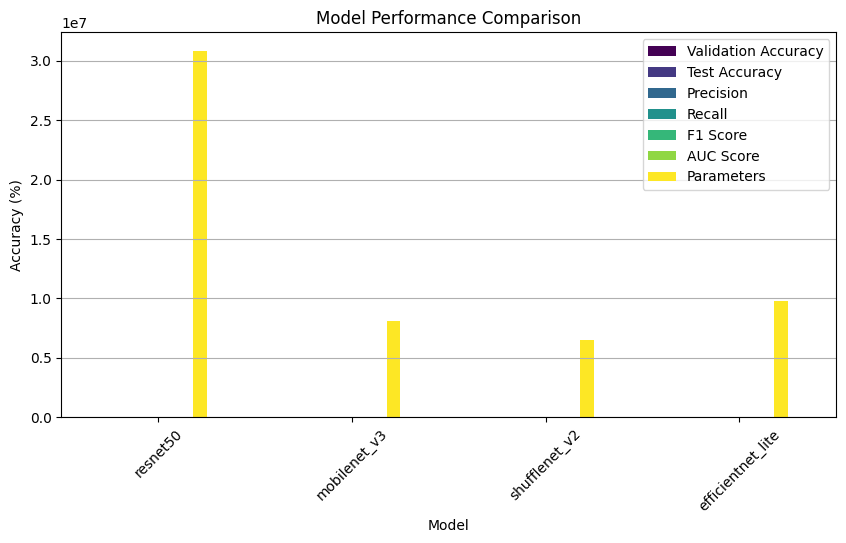

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

real_count = np.sum(np.array(test_labels) == 0)
fake_count = np.sum(np.array(test_labels) == 1)

# 1. Model Performance Comparison (Bar Chart)
plt.figure(figsize=(10, 5))
df_results.set_index("Model").plot(kind="bar", figsize=(10, 5), colormap="viridis")
plt.title("Model Performance Comparison")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()


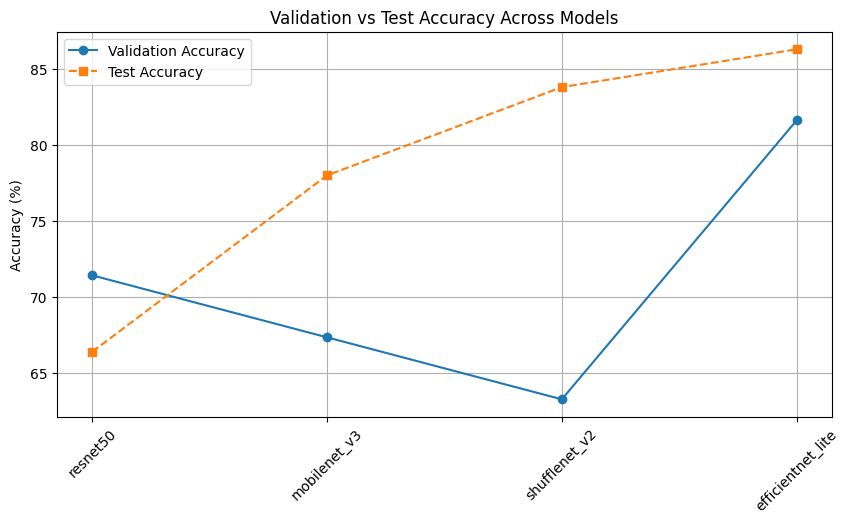

In [15]:
# 2. Line Chart for Validation vs Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(df_results["Model"], df_results["Validation Accuracy"], marker="o", label="Validation Accuracy")
plt.plot(df_results["Model"], df_results["Test Accuracy"], marker="s", label="Test Accuracy", linestyle="dashed")
plt.title("Validation vs Test Accuracy Across Models")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

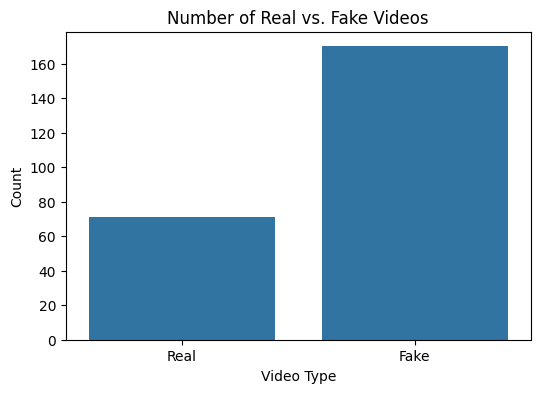

In [16]:
# 3. Real vs Fake Video Count (Countplot)
plt.figure(figsize=(6, 4))
sns.countplot(x=test_labels)
plt.xticks(ticks=[0, 1], labels=["Real", "Fake"])
plt.title("Number of Real vs. Fake Videos")
plt.xlabel("Video Type")
plt.ylabel("Count")
plt.show()

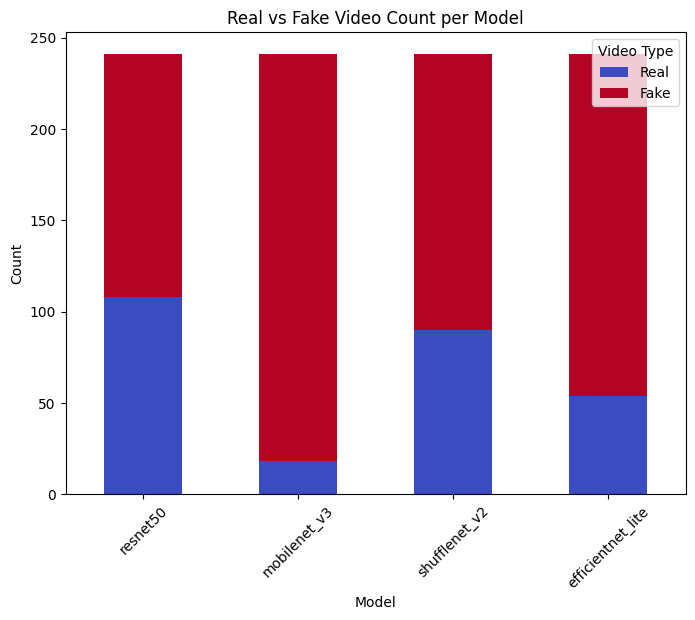

In [17]:
# 4. Stacked Bar Chart for Real vs Fake per Model
df_counts = pd.DataFrame(model_real_fake_counts, index=["Real", "Fake"]).T
df_counts.plot(kind="bar", stacked=True, figsize=(8, 6), colormap="coolwarm")
plt.title("Real vs Fake Video Count per Model")
plt.xlabel("Model")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Video Type")
plt.show()

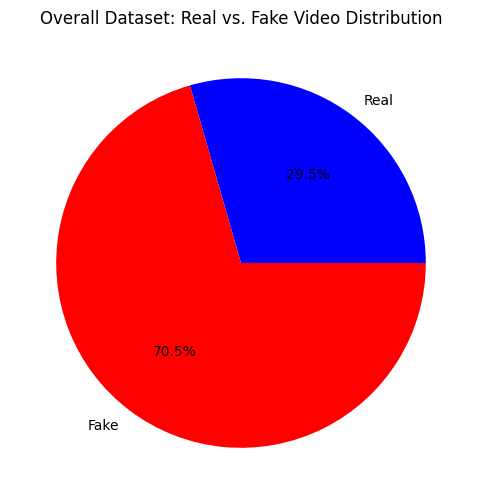

In [18]:
# 5. Pie Chart for Overall Dataset Distribution
plt.figure(figsize=(6, 6))
plt.pie([real_count, fake_count], labels=["Real", "Fake"], autopct='%1.1f%%', colors=['blue', 'red'])
plt.title("Overall Dataset: Real vs. Fake Video Distribution")
plt.show()

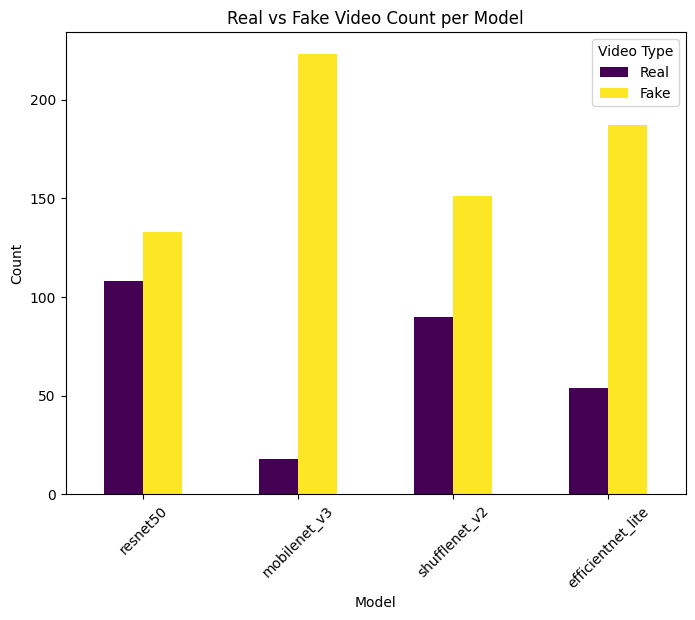

In [19]:
# 6. Side-by-Side Bar Chart for Real vs Fake per Model
df_counts.plot(kind="bar", figsize=(8, 6), colormap="viridis")
plt.title("Real vs Fake Video Count per Model")
plt.xlabel("Model")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Video Type")
plt.show()

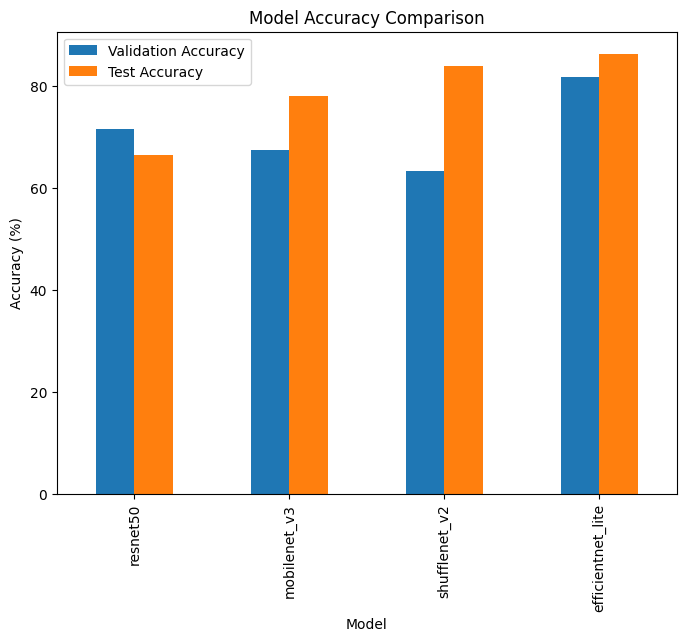

In [20]:
# 7. Model Accuracy Comparison
df_results.plot(x="Model", y=["Validation Accuracy", "Test Accuracy"], kind="bar", figsize=(8, 6), title="Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.show()

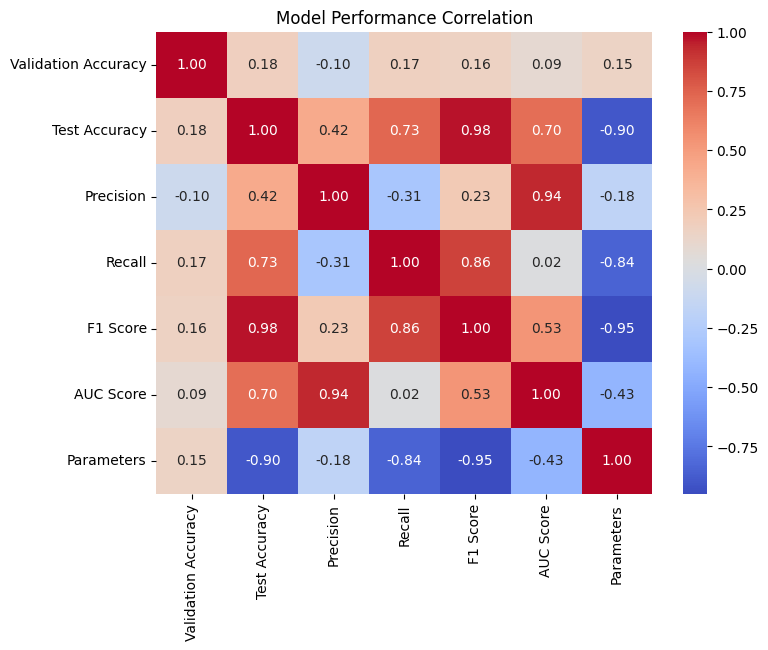

In [21]:
# 8. Correlation Heatmap
df_corr = df_results.drop(columns=["Model"])
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Model Performance Correlation")
plt.show()

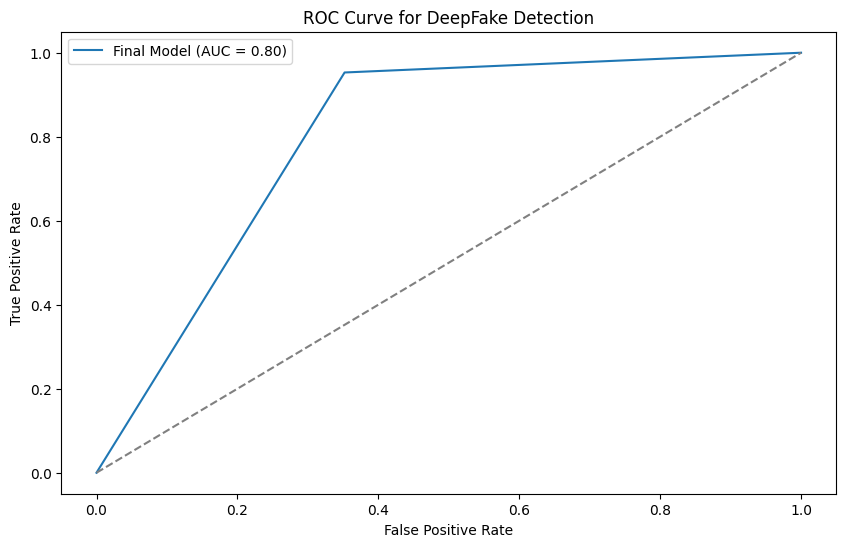

In [22]:
# 9. Improved ROC Curve for Multiple Models (FIX NEEDED)
# This example uses the final test_preds from the last model only!
plt.figure(figsize=(10, 6))
fpr, tpr, _ = roc_curve(test_labels, test_preds)
plt.plot(fpr, tpr, label=f"Final Model (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for DeepFake Detection")
plt.legend()
plt.show()